# Τεχνικές Εξόρυξης Δεδομένων
## Άσκηση 2

### Γρηγόριος Μουλκιώτης - sdi1900117
### Άγγελος Δωρόθεος Χατζόπουλος - sdi1900217

### Εισαγωγή των βιβλιοθηκών και mount των δεδομένων απο το google drive(βρίσκονται μέσα στον φάκελο Colab Notebooks)

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import ast

from google.colab import drive
drive.mount('/content/drive')


# Read csv file and load it to dataframe
mc_dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/books_1.Best_Books_Ever.csv", converters={'characters': ast.literal_eval, 'genres': ast.literal_eval, 'awards': ast.literal_eval, 'ratingsByStars': ast.literal_eval, 'setting': ast.literal_eval})
df = pd.DataFrame(data = mc_dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Προεπεξεργασία

Κάνουμε drop των σειρών που δεν έχουν δεδομένα.Στην συνέχεια δημιουργούμε ξεχωρηστά columns με τον αριθμό των stars σε καθε κατηγορία και παίρνουμε το πρώτο genre από τα genres του κάθε βιβλίου.

In [ ]:
# Reset index after drop

subset_list = ['bookId', 'title', 'author', 'rating', 'description', 'language', 'genres', 'pages', 'publisher', 'publishDate', 'numRatings', 'ratingsByStars']
df=df.dropna(subset=subset_list).reset_index(drop=True)

# Remove rows that have empty lists [] in 'genres' column
df = df[df['genres'].map(lambda d: len(d)) > 0].reset_index(drop=True)

# List Ratings
df2 = pd.DataFrame(df['ratingsByStars'].to_list(), columns=['ratingStar5','ratingStar4','ratingStar3','ratingStar2','ratingStar1'])
df = df.join(df2)
df.pop("ratingsByStars")

# Single genre column
df["genreSingle"] = [x[0] for x in df["genres"].to_list()]

# Remove duplicate rows
df = df.drop_duplicates(subset=["bookId"], keep='first').reset_index(drop=True)

Δημιουργία στήλης με την χρονιά που εκδόθηκε το βιβλίο αφού ορίσουμε το format της εισόδου.

In [ ]:
df['publishDate'] = pd.to_datetime(df['publishDate'], errors ='coerce')
df['publishDate'] = df['publishDate'].dt.strftime('%d/%m/%Y')

publishDate = df['publishDate'].astype(str).str.split(pat='/', n=2, expand=True)
df['publishYear'] = publishDate[2]

Ιστόγραμμα των ratings με βάση το column rating.

### Mελέτη των δεδομένων

#### 1) Κατασκευάστε το ιστόγραμμα των ratings στο σύνολο δεδομένων

<Axes: xlabel='rating', ylabel='Count'>

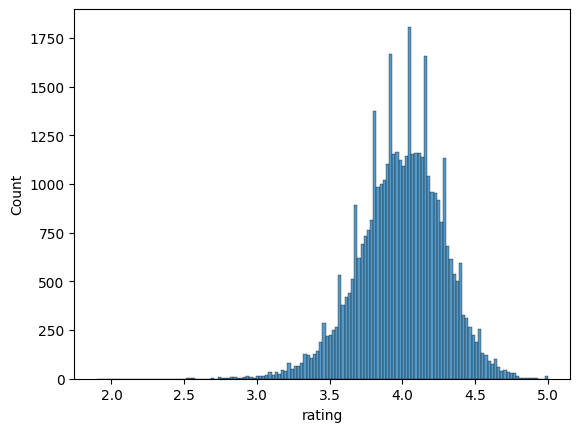

In [ ]:
sns.histplot(data=df['rating'])

#### 2) Ποιά είναι τα 10 βιβλία με τις περισσότερες σελίδες

Barplot με τα βιβλία με τις 10 περισσότερες σελλίδες αφού μετατρέψουμε τα δεδομένα σε αριθμούς στο column pages και κάνουμε drop τα rows που δεν έχουν δεδομένα.

title,pages
The Story of Civilization,14777.000000
The Complete Wheel of Time,11095.000000
The Complete Malazan Book of the Fallen,8258.000000
Animorphs,8245.000000
Homestuck,8124.000000
Worm,6680.000000
سه تفنگدار: ١٠ جلدی,6600.000000
The Complete Aubrey/Maturin Novels (5 Volumes),6576.000000
البداية والنهاية,6088.000000
A Song of Ice and Fire,5216.000000


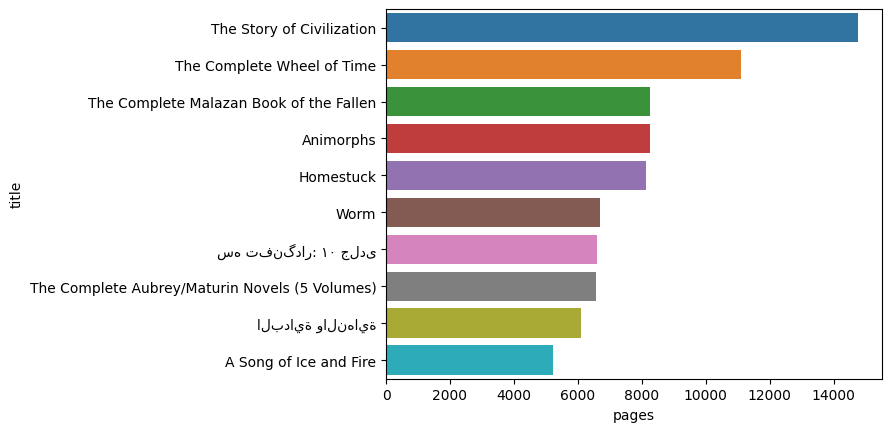

In [ ]:
df['pages'] = pd.to_numeric(df['pages'], errors='coerce')

df = df.dropna(subset=['pages']).reset_index(drop=True)

top_10_pages_df = df.nlargest(10, 'pages')

sns.barplot(data=top_10_pages_df, x="pages", y="title")
top_10_pages_df[['title', 'pages']].style.hide(axis='index')

#### 3) Ποιά είναι τα 10 βιβλία με τα περισσότερα 5-αστέρια.

Barplot με τα βιβλία με τις 10 περισσότερες κριτικές με 5 αστέρια αφού μετατρέψουμε τα δεδομένα σε αριθμούς στο column ratingStar5 και κάνουμε drop τα rows που έχουν λιγότερα απο 10000 5 αστέρια.

title,ratingStar5
Harry Potter and the Sorcerer's Stone,4578137.000000
The Hunger Games,3444695.000000
To Kill a Mockingbird,2363896.000000
Harry Potter and the Deathly Hallows,2038930.000000
Harry Potter and the Prisoner of Azkaban,1892635.000000
The Fault in Our Stars,1784471.000000
Twilight,1751460.000000
Harry Potter and the Goblet of Fire,1729403.000000
Harry Potter and the Half-Blood Prince,1646703.000000
Pride and Prejudice,1617567.000000


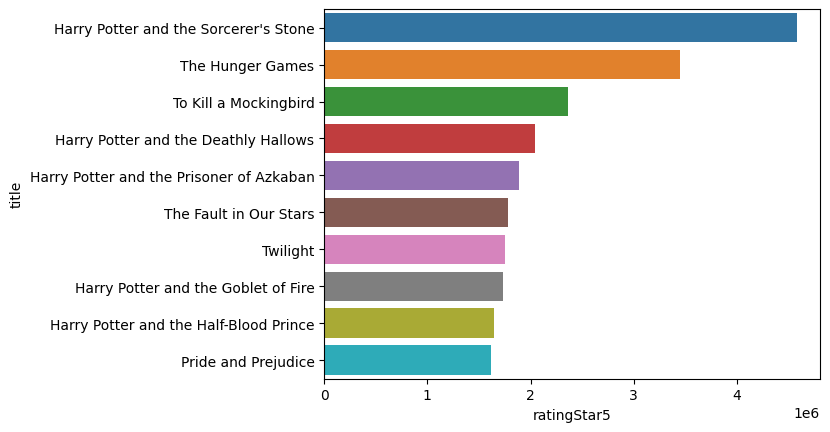

In [ ]:
df['ratingStar5'] =  pd.to_numeric(df['ratingStar5'])
df_top_rating = df.nlargest(10, 'ratingStar5')

df_top_rating.drop(df_top_rating[df_top_rating['ratingStar5'] < 10000].index, inplace=True)

sns.barplot(data=df_top_rating, x="ratingStar5", y="title")
df_top_rating[['title', 'ratingStar5']].style.hide(axis='index')

#### 4) Ποιές είναι οι πιο συχνές λέξεις στους τίτλους των βιβλίων (αφού αφαιρεθούν τα stopwords)

Αφού βγάλουμε τα stopwords και στριπάρουμε το κείμενο απο σύμβολα βρίσκουμε τις πιο συχνά χρησιμοποιούμενες λέξεις.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: >

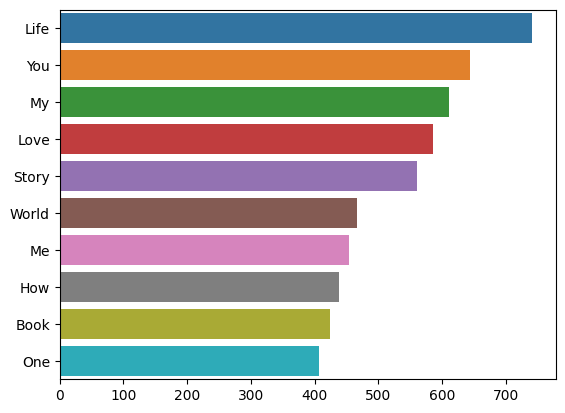

In [ ]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

stop = stopwords.words('english')

# Numbers removal
stopwords_numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

# Some extra words to remove
extras = ['The', 'A', 'La', 'Volume', 'Vol.', 'Vol', '&', '/', 'de', '-', 'Il', 'I', 'II', '1:', '3:', '4:', '2:', '6:']

stop.extend(extras + stopwords_numbers)

df_titles = df['title'].apply(lambda x: ' '.join([word.strip("'-:()[]{}!?$%^&*_~;/.,`+=#@") for word in x.split() if word.strip("'-:()[]{}!?$%^&*_~;/.,`+=#@") not in (stop)]))

top_words_freq = df_titles.str.split(expand=True).stack().value_counts()

sns.barplot(x=top_words_freq[:10], y=top_words_freq[:10].index)

#### Ποιοι είναι οι 10 συγγραφεις με τα περισσότερα βιβλία

Barplot με τους συγγραφείς με τα 10 περισσότερα βιβλία.

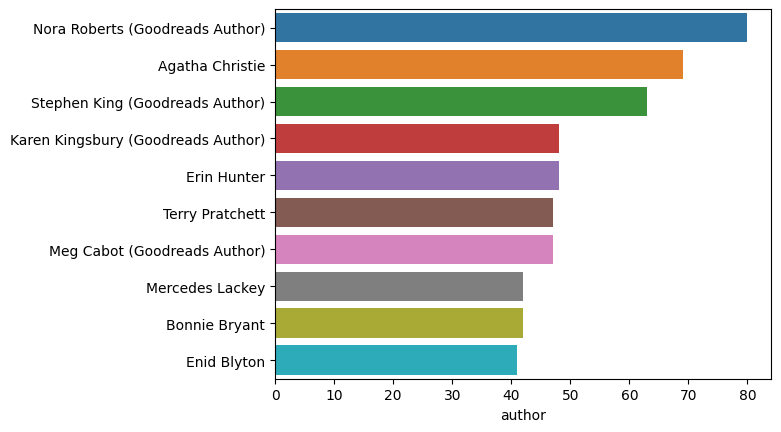

In [ ]:
df_authors = df['author'].value_counts().nlargest(10)
plot = sns.barplot(x=df_authors, y=df_authors.index)

### Υλοποίηση Recommendation system

Κρατάμε μόνο την λίστα με τα βιβλία που έχουν language english και τις στήλες bookId και desciption και τα αποθηκεύουμε σε ενα dataframe.

In [ ]:
df = df.head(5000)

df_rec = df[df['language'] == 'English'][['bookId', 'description']].copy().reset_index(drop=True)
df_rec

,bookId,description
0,2767052-the-hunger-games,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,There is a door at the end of a silent corrido...
2,2657.To_Kill_a_Mockingbird,The unforgettable novel of a childhood in a sl...
3,1885.Pride_and_Prejudice,Alternate cover edition of ISBN 9780679783268S...
4,41865.Twilight,About three things I was absolutely positive.\...
...,...,...
4835,18334246-sweet-thing,"""You have to teach your heart and mind how to ..."
4836,22895264-wicked,Things are about to get Wicked in New Orleans....
4837,26264353-everything-and-a-happy-ending,A memoir about 3 interconnected relationships ...
4838,7818881-twelfth-grade-kills,It all comes down to this.Vlad’s running out o...


Εκτελούμε προεπεξεργασία του κειμένου.

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

  text = text.lower()

  text = text.translate(str.maketrans('', '', string.punctuation))

  stop_words = set(stopwords.words('english'))

  word_tokens = word_tokenize(text)
  text = [w for w in word_tokens if not w in stop_words]

  text = ' '.join([lemmatizer.lemmatize(word) for word in text])

  return text


df_rec['description'] = df_rec['description'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Δημιουργούμε τον πίνακα tf-idf των unigrams και bigrams.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df_rec['description'])

Δημιουργούμε ενα dictionary ομοιοτήτων.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_array = cosine_similarity(tfidf, tfidf)

Για κάθε βιβλίο κάνουμε map τα 100 πιό όμοια βιβλία και τα αποθηκεύουμε σε ενα python dictionary.

In [ ]:
def get_recommendations(bookId, cosine_sim, indices):

    idx = indices[bookId]
    sim_scores = [(index, sim_score) for index, sim_score in list(enumerate(cosine_sim[idx])) if index != idx]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:100]
    scores_inds = [i[0] for i in sim_scores]

    return [(book_id, score) for book_id, score in zip(df_rec['bookId'].iloc[scores_inds], [tup[1] for tup in sim_scores])]


df_rec.reset_index(drop=True, inplace=True)
indices = pd.Series(df_rec.index, index=df_rec['bookId'])

rec_dict = {}

for i, bookid in enumerate(df_rec['bookId']):
  rec_dict[bookid] = get_recommendations(bookid, sim_array, indices)

Συνάρτηση η οποία παίρνει σαν είσοδο ένα id και ένα ακέραιο αριθμό N,
και επιστρέφει τα Ν πιο όμοια βιβλία με βάση το python dictionary.

In [ ]:
def recommend(item_id, num):

  book_title = df.loc[df['bookId'] == item_id, 'title'].values[0]
  print(f'Recommending {num} books similar to {book_title}')
  print('---------------------------------------------\n')

  books_list = rec_dict[item_id][:num]

  for rec_book, score in books_list:
    rec_title  = df.loc[df['bookId'] == rec_book, 'title'].values[0]
    rec_desc = df.loc[df['bookId'] == rec_book, 'description'].values[0]

    print(f'Recommended: {rec_title}')
    print(f'Description:  {rec_desc}')
    print(f'(Score: {score})')
    print()


recommend('17245.Dracula', 5)

Recommending 5 books similar to Dracula
---------------------------------------------

Recommended: Clown Girl
Description:  Drake has created a novel that blends the high comedy of early film stars--most notably Chaplin and W.C. Fields--to raise questions of class, gender, economics, and prejudice. Resisting easy classification, this debut novel blends the bizarre, the humorous, and the gritty with great skill.
(Score: 0.35855287568930866)

Recommended: The Talented Mr. Ripley
Description:  Since his debut in 1955, Tom Ripley has evolved into the ultimate bad boy sociopath, influencing countless novelists and filmmakers. In this first novel, we are introduced to suave, handsome Tom Ripley: a young striver, newly arrived in the heady world of Manhattan in the 1950s. A product of a broken home, branded a "sissy" by his dismissive Aunt Dottie, Ripley becomes enamored of the moneyed world of his new friend, Dickie Greenleaf. This fondness turns obsessive when Ripley is sent to Italy to br

### Υλοποίηση Κατηγοριοποίησης (Classification)

In [ ]:
import os
import gensim
from gensim.models import word2vec
from sklearn.model_selection import train_test_split


df_class = pd.DataFrame()

# Keep bookId, description, genreSingle
df_class[['bookId', 'description', 'genreSingle']] = df[['bookId', 'description', 'genreSingle']]

# Keep top 10 genres
df_top_genres = df['genreSingle'].value_counts().nlargest(10).reset_index()
df_top_genres.columns = ['genreSingle', 'count']

df_class = df_class.loc[df['genreSingle'].isin(df_top_genres['genreSingle'])]


# Open pkl or train word2vec model
if os.path.exists('word2vec_model.pkl'):
  with open('word2vec_model.pkl', 'rb') as f:
    model = gensim.models.Word2Vec.load("word2vec_model.pkl")

else:

  # Apply preprocess
  lemmatizer = WordNetLemmatizer()
  df_class['description'] = df_class['description'].apply(preprocess_text)

  desc = [s.encode('utf-8').split() for s in df_class['description']]

  model = word2vec.Word2Vec(desc, vector_size=300, min_count=1, window=5, workers=4)
  model.save("word2vec_model.pkl")

# Get mean from all the embeddings
embeddings = np.array([model.wv[d] for d in desc], dtype=object)

embeddings_mean = []
for word in embeddings:
    word_embedding = np.mean(word, axis=0)
    embeddings_mean.append(word_embedding)

word_embeddings = np.array(embeddings_mean)

# Get X and Y arrays and split into train and test set
X = word_embeddings
Y = df_class['genreSingle']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Ακολουθεί classification με Naive Bayes.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()

Y_pred = gnb.fit(X_train, Y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != Y_pred).sum()))

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Naive Bayes Classification Accurancy: {accuracy}')

Number of mislabeled points out of a total 804 points : 677
Naive Bayes Classification Accurancy: 0.15796019900497513


Ακολουθεί classification με SVM. Επιλογή optimal παραμέτρων με χρήση GridSearchCV.

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters_test = {
              'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear']
             }

grid_result = GridSearchCV(svm.SVC(), parameters_test, refit=True, n_jobs=-1)
grid_result.fit(X_train, Y_train)

Y_pred = grid_result.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

svm_params_dict = grid_result.best_params_
print(f'Best paramaters for SVM: {svm_params_dict}')
print(f'SVM Classification Accurancy: {accuracy}')

Best paramaters for SVM: {'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVM Classification Accurancy: 0.39552238805970147


Ακολουθεί classification με Random Forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)


Y1_pred = clf.predict(X_train)
accuracy1 = accuracy_score(Y1_pred, Y_train)

print(f'Random Forest Classification Training: {accuracy1}')

Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print(f'Random Forest Classification: {accuracy}')

Random Forest Classification Training: 0.3523009950248756
Random Forest Classification: 0.3283582089552239


Παρουσίαση των μετρικών των classifiers με την χρήση 10-fold Cross Validation.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


X = pd.DataFrame(X)
Y = pd.DataFrame(Y)


scores_list = {'precision_score': make_scorer(precision_score, average='weighted', zero_division=1), 'recall_score': make_scorer(recall_score, average='weighted', zero_division=1),
               'f1_score':make_scorer(f1_score, average='weighted', zero_division=1),  'accuracy_score': make_scorer(accuracy_score)}

classifiers = [GaussianNB(), svm.SVC(kernel=svm_params_dict['kernel'], C=svm_params_dict['C'], gamma=svm_params_dict['gamma']), RandomForestClassifier(max_depth=2, random_state=0)]
classifiers_names = ['Naive Bayes', f"SVM, Kernel: {svm_params_dict['kernel']}", 'Random Forest']

df_scores = pd.DataFrame(columns=['Model', 'Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score'])

for classifier, name in zip(classifiers, classifiers_names):
  accuracy = cross_validate(classifier, X, Y.values.ravel(), cv=10, scoring=scores_list)
  scores = {'Model': name, 'Precision Score': np.mean(accuracy['test_precision_score']), 'Recall Score': np.mean(accuracy['test_recall_score']),
            'F1 Score': np.mean(accuracy['test_f1_score']), 'Accuracy Score': np.mean(accuracy['test_accuracy_score'])}
  df_scores = pd.concat([df_scores, pd.DataFrame([scores])], ignore_index=True)

df_scores

,Model,Precision Score,Recall Score,F1 Score,Accuracy Score
0,Naive Bayes,0.294686,0.169154,0.132769,0.169154
1,"SVM, Kernel: linear",0.575036,0.392786,0.298637,0.392786
2,Random Forest,0.600761,0.341045,0.255169,0.341045


**BONUS - Judging a book by its cover..!**

Εισαγωγή ετικετων και path όπου υπάρχει ο φάκελος των Colab Notebooks(εκεί μέσα θα γίνει και η λήψη των εικόνων)

In [ ]:
import os
import csv
import time
import urllib.request

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
DIR_PATH = "/content/drive/My Drive/Colab Notebooks/"

Λήψη εικόνων

In [ ]:
def get_books_cover(DIR_PATH, books, bookIds):
        """
        Retrieves books covers to a img/ directory
        Will work on existing books class attribute, so a GoodReads list should be scraped or a books list loaded
        (csv_to_books) before use.
        :return: None
        """
        img_dir = DIR_PATH + "img"
        check_folder = os.path.isdir(img_dir)

        # If folder doesn't exist, then create it.
        if not check_folder:
            os.makedirs(img_dir)
            print("Creating folder: ", img_dir)

        else:
            print(img_dir, "folder already exists, saving images to folder.")

        count = 0
        # Download covers
        for (book, bookId) in zip(books, bookIds):
            try:
                urllib.request.urlretrieve(str(book), f'{img_dir}/' + str(bookId)  + ".jpg")
                # Set a respectful wait time
                time.sleep(2)

                count += 1
                if count == 500:
                  break

            except ValueError:
              continue

In [ ]:
import pandas as pd
file = DIR_PATH + "books_1.Best_Books_Ever.csv"

In [ ]:
finalbooks = pd.read_csv(file)
finalbooks.head()

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",...,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


In [ ]:
images = finalbooks['coverImg']
Ids = finalbooks['bookId']

In [ ]:
# Get the images
# get_books_cover(DIR_PATH, images, Ids)

Φόρτωμα των εικόνων.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

IMAGES_DIR = DIR_PATH + 'img'

def load_images(folder):
    images = []

    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img_bgr)

    return images

def split_set(images):
  total_test = int(0.05 * len(images))
  return images[total_test:], images[:total_test]

images = load_images(IMAGES_DIR)

images, test_images = split_set(images)

Υπολογισμός του histogram για κάθε εικόνα.

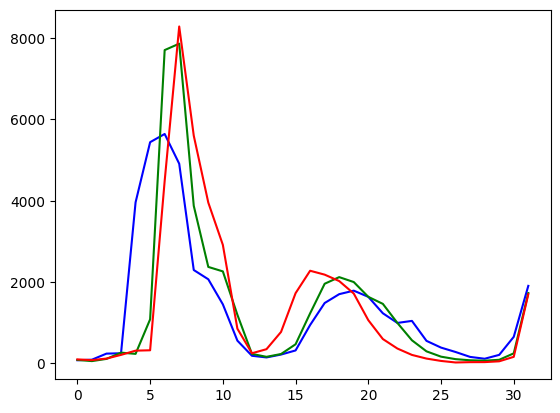

In [ ]:
bgr_colors = ['b','g','r']

for i in range(3):
    hist = cv2.calcHist(images, [i], None, [32], [0, 256])
    plt.plot(hist, color = bgr_colors[i])

plt.show()

Δημιουργία datagram από τα histograms κάθε εικόνας

In [ ]:
bgr_list = []

old_shape = None

for image in images:
  hist_vector = []

  for i in range(3):
    hist = cv2.calcHist([image], [i], None, [32], [0, 256])
    hist_vector.append(hist)

  old_shape = np.array(hist_vector).shape
  bgr_list.append(np.array(hist_vector).flatten())


df = pd.DataFrame(bgr_list, columns=[str(i) for i in range(96)])
df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,76.0,90.0,239.0,248.0,3961.0,5441.0,5643.0,4911.0,2296.0,2068.0,...,364.0,207.0,117.0,59.0,21.0,29.0,30.0,50.0,160.0,1702.0
1,9.0,8.0,29.0,24.0,65.0,155.0,330.0,328.0,259.0,293.0,...,206.0,161.0,110.0,80.0,39.0,31.0,12.0,3.0,4.0,3.0
2,6287.0,3805.0,6892.0,13721.0,10739.0,11568.0,18237.0,5840.0,1346.0,999.0,...,260.0,358.0,316.0,468.0,649.0,696.0,971.0,6921.0,12483.0,31123.0
3,29776.0,8216.0,4806.0,4311.0,4953.0,4382.0,3984.0,3511.0,3582.0,3956.0,...,832.0,654.0,474.0,409.0,366.0,331.0,264.0,309.0,667.0,1645.0
4,29132.0,27445.0,14443.0,6812.0,3724.0,2230.0,1799.0,1557.0,1484.0,1474.0,...,1088.0,990.0,835.0,874.0,936.0,1031.0,1008.0,642.0,478.0,1333.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,12050.0,10092.0,4385.0,3266.0,2816.0,2585.0,2445.0,2397.0,2311.0,2325.0,...,4016.0,4424.0,5059.0,5790.0,6467.0,7145.0,7028.0,8164.0,10625.0,12994.0
471,25376.0,718.0,329.0,266.0,273.0,280.0,275.0,224.0,255.0,374.0,...,1316.0,2111.0,9046.0,18863.0,686.0,299.0,435.0,347.0,640.0,26319.0
472,16019.0,16976.0,14100.0,9545.0,9778.0,8246.0,8247.0,8981.0,13182.0,6254.0,...,2140.0,1993.0,1680.0,1254.0,1025.0,794.0,972.0,1928.0,2576.0,2021.0
473,14668.0,2474.0,1235.0,899.0,836.0,822.0,719.0,713.0,698.0,688.0,...,2149.0,2110.0,2471.0,2903.0,2928.0,3528.0,17161.0,12326.0,5722.0,9176.0


Επιλογή τυχαίας εικόνας και υπολογισμός ιστογράμματος της.

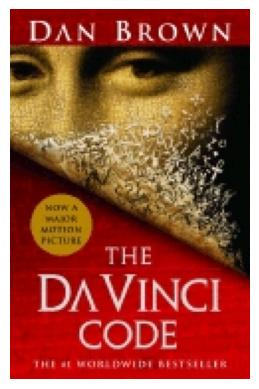

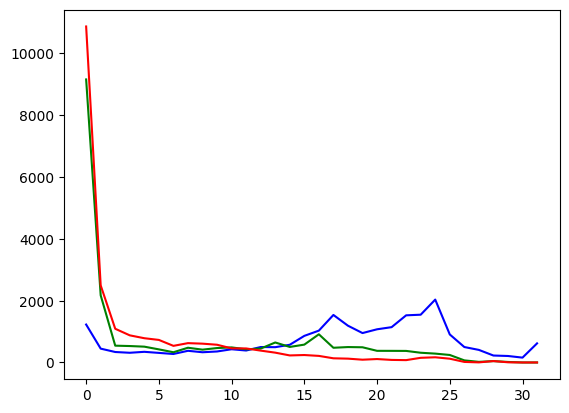

In [ ]:
import random

random_image = random.choice(test_images)
plt.imshow(random_image)
plt.axis('off')
plt.show()

bgr_colors = ['b','g','r']
for i in range(3):
    hist = cv2.calcHist([random_image], [i], None, [32], [0, 256])
    plt.plot(hist, color = bgr_colors[i])

plt.show()

Εμφάνιση πιο κοντινών εικόνων με cosine similarity.Εμφανίζονται στην συνέχεια οι 4 κοντινότερες εικόνες.

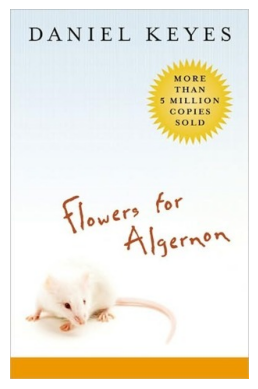

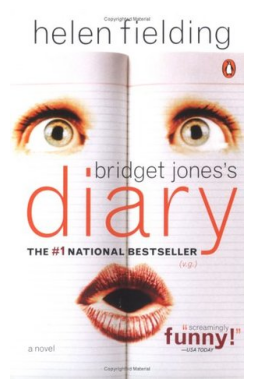

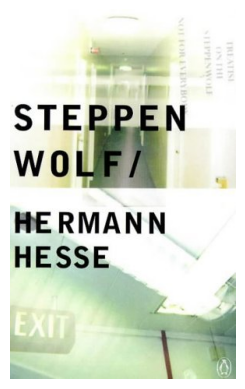

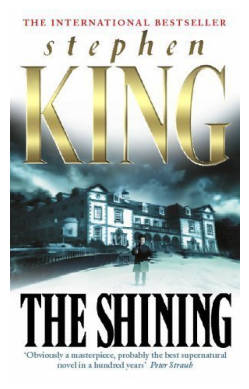

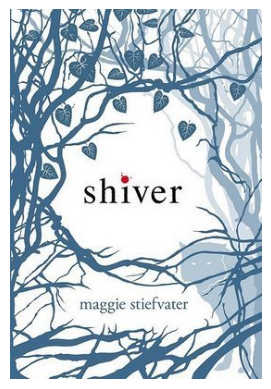

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_books(index, cosine_sim, indices):

    idx = indices[index]

    sim_scores = [(index, sim_score) for index, sim_score in list(enumerate(cosine_sim[idx])) if index != idx]

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    sim_scores = sim_scores[:4]
    book_cover = [i[0] for i in sim_scores]

    return [index for index in [tup[0] for tup in sim_scores]]



cosine_vector = cosine_similarity(df, df)
indices = pd.Series(df.index)

sim_books = get_similar_books(90, cosine_vector, indices)

plt.imshow(images[90])
plt.axis('off')
plt.show()

for index in sim_books:
  plt.imshow(images[index])
  plt.axis('off')
  plt.show()